In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import RobustScaler, StandardScaler,MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
import joblib
from sklearn.metrics import confusion_matrix, f1_score, r2_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold, StratifiedKFold

## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('../Data/Covid-19.csv')
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,DEATH,INFECTED
0,2,1,1,1,1,65,2,2,2,2,2,1,2,2,2,2,2,1,1
1,2,1,2,1,1,72,2,2,2,2,2,1,2,2,1,1,2,1,2
2,2,1,2,2,2,55,2,1,2,2,2,2,2,2,2,2,2,1,1
3,2,1,1,1,2,53,2,2,2,2,2,2,2,2,2,2,2,1,2
4,2,1,2,1,2,68,2,1,2,2,2,1,2,2,2,2,2,1,1


In [3]:
# Splitting the datasets and choosing 10 columns that are correlated with the DEATH Column
X = SelectKBest(k=14, score_func=f_classif).fit_transform(df.drop(['DEATH'],axis=1), df['DEATH'])
y = df['DEATH']

In [4]:
# # Scaling the numeric feature
# scaler = RobustScaler()
# df['AGE'] = scaler.fit_transform(df.AGE.values.reshape(-1,1))
# df['MEDICAL_UNIT'] = scaler.fit_transform(df.MEDICAL_UNIT.values.reshape(-1,1))
# df.head()
scaler = RobustScaler()
X = scaler.fit_transform(X)

In [5]:
# Splitting the data into train and test, since the data is imbalance I would Undersample the majority class
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print("X_train :",X_train.shape)
print("X_test :",X_test.shape)
print("y_train :",y_train.shape)
print("y_test :",y_test.shape)

X_train : (119451, 14)
X_test : (29863, 14)
y_train : (119451,)
y_test : (29863,)


In [6]:
# plt.figure()
# sns.barplot(y_resampled.value_counts().index,y_resampled.value_counts().values).set(title="DEATHS Counts",xticklabels=(["Dead","Alive"]),ylabel="Value")
# # plt.savefig("myfirstplot.jpeg")
# plt.show()

In [7]:
# # Export splitted data
# pd.DataFrame(X_train).to_csv("../Data/features/X_train.csv", index=False)
# pd.DataFrame(X_test).to_csv("../Data/features/X_test.csv", index=False)
# pd.DataFrame(y_train).to_csv("../Data/features/y_train.csv", index=False)
# pd.DataFrame(y_test).to_csv("../Data/features/y_test.csv", index=False)

## Models

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn import metrics

In [9]:
models = {"Logistic Regression": LogisticRegression(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
          "Gradient Boosting": GradientBoostingClassifier(),
          "Decision Tree": DecisionTreeClassifier(),
          "XGB Classifier": XGBClassifier()
         }

# Creating a function to fit and score the models
def fit_and_score(models, X_train, X_test, y_train, y_test):
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [10]:
model_scores = fit_and_score(models = models,
                            X_train = X_train,
                            X_test = X_test,
                            y_train = y_train,
                            y_test = y_test)
model_scores

[17:22:05] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'Logistic Regression': 0.9050999564678699,
 'KNN': 0.9027559186953755,
 'Random Forest': 0.8975990355958879,
 'Gradient Boosting': 0.9147774838428825,
 'Decision Tree': 0.8885242607909453,
 'XGB Classifier': 0.9143086762883836}

**We would proceed by hyper-tuning using randomgridcv on Logistic Regression, Gradient Boosting, XGB Classifier. My computer couldn't handle the work load**

## Logistic Regression

In [11]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
print("Logistic Regression Accuracy: ",lr.score(X_test,y_test))

Logistic Regression Accuracy:  0.9050999564678699


Logistic Regression F1 Score:  [0.90614029 0.9040363 ]
Logistic Regression R2 Score:  0.6203967504764767


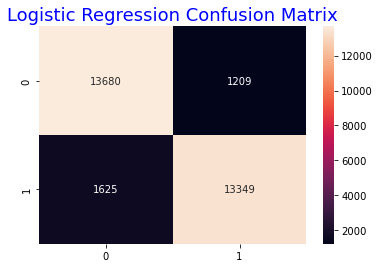

In [12]:
print("Logistic Regression F1 Score: ", f1_score(y_test,lr.predict(X_test),average=None))
print("Logistic Regression R2 Score: ", r2_score(y_test,lr.predict(X_test)))
plt.figure()
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test)), annot=True, fmt=".0f")
plt.title("Logistic Regression Confusion Matrix",fontsize=18, color="b")
# plt.savefig("../Images/plots/log_reg_conf_matrix.jpeg")
plt.show()

In [13]:
y_preds = lr.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.89      0.92      0.91     14889
           2       0.92      0.89      0.90     14974

    accuracy                           0.91     29863
   macro avg       0.91      0.91      0.91     29863
weighted avg       0.91      0.91      0.91     29863



### Grid Search Cross Validation with Logistic Regression

In [14]:
grid = {"C":np.logspace(-3,3,7),"penalty":["l1","l2"]}
logreg = LogisticRegression(random_state=42)
logreg_cv = GridSearchCV(logreg,
                         grid,
                         cv=10,
                         n_jobs=-1,
                         verbose=1,
                        )
logreg_cv.fit(X_train,y_train)

print("Optimized hyperparameters: ",logreg_cv.best_params_)
print("accuracy: ",logreg_cv.best_score_)

Fitting 10 folds for each of 14 candidates, totalling 140 fits
Optimized hyperparameters:  {'C': 0.001, 'penalty': 'l2'}
accuracy:  0.9070581548880104


Logistic Regression F1 Score:  [0.90674794 0.90470226]
Logistic Regression R2 Score:  0.6229417263907135


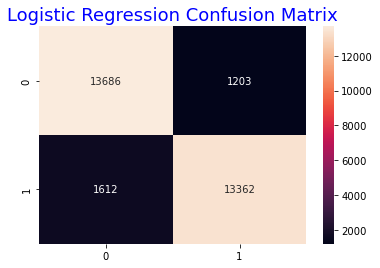

In [15]:
print("Logistic Regression F1 Score: ", f1_score(y_test,logreg_cv.predict(X_test),average=None))
print("Logistic Regression R2 Score: ", r2_score(y_test,logreg_cv.predict(X_test)))
plt.figure()
sns.heatmap(confusion_matrix(y_test, logreg_cv.predict(X_test)), annot=True, fmt=".0f")
plt.title("Logistic Regression Confusion Matrix",fontsize=18, color="b")
# plt.savefig("../Images/plots/log_reg_cv_conf_matrix.jpeg")
plt.show()

In [16]:
y_preds = logreg_cv.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.89      0.92      0.91     14889
           2       0.92      0.89      0.90     14974

    accuracy                           0.91     29863
   macro avg       0.91      0.91      0.91     29863
weighted avg       0.91      0.91      0.91     29863



In [17]:
## Save the model as a pickle in a file
# joblib.dump(logreg_cv, '../Models/Logreg_cv.pkl')

## Gradient Boosting Classifier

In [18]:
gb = GradientBoostingClassifier()
gb.fit(X_train,y_train)
print("Gradient Boosting Classifier Accuracy: ",gb.score(X_test,y_test))

Gradient Boosting Classifier Accuracy:  0.9147774838428825


Gradient Boosting Classifier F1 Score:  [0.91743179 0.91194686]
Gradient Boosting Classifier R2 Score:  0.6591071735930252


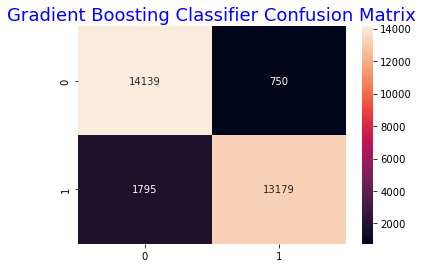

In [19]:
print("Gradient Boosting Classifier F1 Score: ", f1_score(y_test,gb.predict(X_test),average=None))
print("Gradient Boosting Classifier R2 Score: ", r2_score(y_test,gb.predict(X_test)))
plt.figure()
sns.heatmap(confusion_matrix(y_test, gb.predict(X_test)), annot=True, fmt=".0f")
plt.title("Gradient Boosting Classifier Confusion Matrix",fontsize=18, color="b")
# plt.savefig("../Images/plots/grad_boost_conf_matrix.jpeg")
plt.show()

In [20]:
y_preds = gb.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.89      0.95      0.92     14889
           2       0.95      0.88      0.91     14974

    accuracy                           0.91     29863
   macro avg       0.92      0.91      0.91     29863
weighted avg       0.92      0.91      0.91     29863



In [21]:
# # Save the model as a pickle in a file
# joblib.dump(gb, '../Models/gradboostclassifier.pkl')

## XGBoost Classifier

In [22]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
print("XGB Classifier Accuracy: ",xgb.score(X_test,y_test))

[17:22:55] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB Classifier Accuracy:  0.9143086762883836


XGB Classifier F1 Score:  [0.91711741 0.9113029 ]
XGB Classifier R2 Score:  0.657231928182535


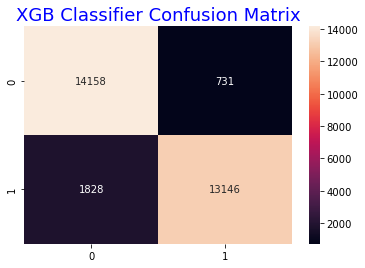

In [23]:
print("XGB Classifier F1 Score: ", f1_score(y_test,xgb.predict(X_test),average=None))
print("XGB Classifier R2 Score: ", r2_score(y_test,xgb.predict(X_test)))
plt.figure()
sns.heatmap(confusion_matrix(y_test, xgb.predict(X_test)), annot=True, fmt=".0f")
plt.title("XGB Classifier Confusion Matrix",fontsize=18, color="b")
plt.savefig("../Images/plots/XGB_class_conf_matrix.jpeg")
plt.show()

In [24]:
y_preds = xgb.predict(X_test)
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.89      0.95      0.92     14889
           2       0.95      0.88      0.91     14974

    accuracy                           0.91     29863
   macro avg       0.92      0.91      0.91     29863
weighted avg       0.92      0.91      0.91     29863



In [25]:
# # Save the model as a pickle in a file
# joblib.dump(xgb, '../Models/XGBclassifier.pkl')

### Hyperparamter Tuning with RandomizedSearchCV

In [26]:
# # Create a hyperparameter grid for LogisticRegression
# logreg_grid = {"C": np.logspace(-4, 4, 50),
#                "penalty" : ['l1', 'l2', 'none'],
#                 "solver": ["liblinear", 'newton-cg']}

# # Tune LogisticRegression
# # Setup random hyperparameter search for LogisticRegression
# rs_log_reg = RandomizedSearchCV(LogisticRegression(),
#                                 param_distributions=logreg_grid,
#                                 cv=5,
#                                 n_iter=500,
#                                 verbose=True,
#                                 random_state=42)

# # Fit random hyperparameter search model for LogisticRegression
# rs_log_reg.fit(X_train, y_train)

In [27]:
# # Finding the best hyperparameter
# rs_log_reg.best_params_

In [28]:
# rs_log_reg.score(X_test, y_test)

In [29]:
# # XGBoost
# # n_jobs=-1 to allow run it on all cores
# params = {
#     'n_estimators': [100, 200, 500],
#     'learning_rate': [0.01,0.05,0.1],
#     'booster': ['gbtree', 'gblinear'],
#     'gamma': [0, 0.5, 1],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0.5, 1, 5],
#     'base_score': [0.2, 0.5, 1]
# }

# # Set up the k-fold cross-validation
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# XGB_randomsearch = RandomizedSearchCV(XGBClassifier(), 
#                                       params,
#                                       n_iter=150,
#                                       n_jobs=-1, 
#                                       cv=kfold, 
#                                       verbose=True, 
#                                       scoring='roc_auc', 
#                                       random_state=42)

# XGB_randomsearch.fit(X_train, y_train)

# print('Best score:', XGB_randomsearch.best_score_)
# print('Best score:', XGB_randomsearch.best_params_)

### GridSearchCV

In [30]:
# # Different hyperparameter grid for LogisticRegression
# log_reg_grid = {"penalty":['l1', 'none', 'elasticnet'],
#                 "C": np.logspace(-4, 4, 80),
#                 "solver": ["liblinear", "saga", "newton-cg"]
#                 }

# # Setup grid hyperparameter search for LogisticRegression
# gs_log_reg = GridSearchCV(LogisticRegression(),
#                           param_grid=log_reg_grid,
#                           cv=5,
#                           verbose=True)

# # Fit grid hyperparameter search model
# gs_log_reg.fit(X_train, y_train)

In [31]:
# gs_log_reg.best_params_

In [32]:
# gs_log_reg.score(X_test, y_test)

In [33]:
# # XGBoost
# # n_jobs=-1 to allow run it on all cores
# params = {
#     'n_estimators': [100, 200, 500],
#     'learning_rate': [0.01,0.05,0.1],
#     'booster': ['gbtree', 'gblinear'],
#     'gamma': [0, 0.5, 1],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0.5, 1, 5],
#     'base_score': [0.2, 0.5, 1]
# }

# # Set up the k-fold cross-validation
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# XGB_gridsearch = GridSearchCV(XGBClassifier(), 
#                    params, 
#                    n_jobs=-1, 
#                    cv=kfold, 
#                    verbose=True)
# XGB_gridsearch.fit(X_train, y_train)

# print('Best score:', XGB_gridsearch.best_score_)
# print('Best score:', XGB_gridsearch.best_params_)